In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date

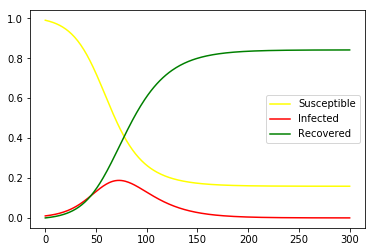

Cumulative number of infected people: 84.1%
Duration before the peak: 73


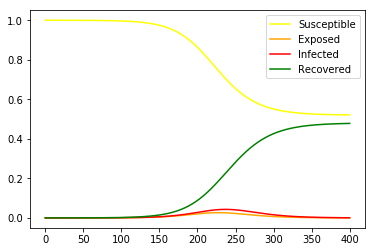

Cumulative number of infected people: 0.47809741537306305
Duration before the peak: 237


corona_sir_seir.ipynb:8: RuntimeWarning: overflow encountered in double_scalars
  ]
corona_sir_seir.ipynb:8: RuntimeWarning: invalid value encountered in double_scalars
  ]


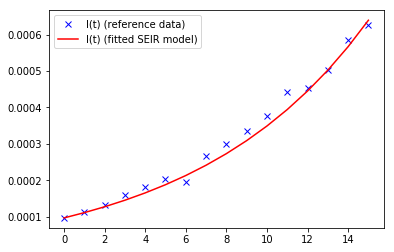

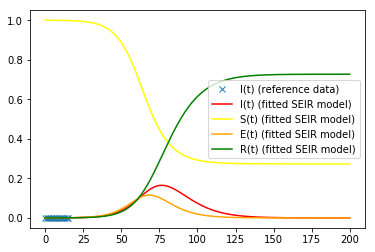

In [2]:
run corona_sir_seir.ipynb

In [4]:
with open('covid_19_data.csv') as csv:
    data_csv = pd.read_csv(csv)

data_csv = data_csv[data_csv['ObservationDate'].notna()]
data_csv['ObservationDate'] = data_csv.apply(lambda row: clean_date(row['ObservationDate']), axis=1)
data_csv['Confirmed'] = data_csv.apply(lambda row: int(row['Confirmed']), axis=1)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
def analyze_data(I_ref):
    n_grid = 20
    grid_rho_e = np.linspace(0, 1, n_grid)
    grid_rho_i = np.linspace(0, 1, n_grid)
    grid_c_e = np.linspace(.1, 10, n_grid)
    grid_c_i = np.linspace(.1, 10, n_grid)

    # Regularization parameters
    T = 200
    regularization_methods = {
        'p_e': 1,
        'p_i': 1,
        'max': 0,
        'tikhonov': 0
    }

    # Grid search
    best_rho_e, best_rho_i, best_c_e, best_c_i, best_J = grid_search(I_ref, grid_rho_e, grid_rho_i, grid_c_e, grid_c_i, regularization_methods, T) 

    # Fitted model
    S_list, E_list, I_list, R_list = SEIR(1.5*I_ref[0], I_ref[0], best_rho_e, best_rho_i, best_c_e, best_c_i, 6, 10, T)
    
    # Plot result
    plt.plot(I_ref, linestyle='None', marker='x', c='blue', label='I(t) (reference data)')
    plt.plot(I_list[:len(I_ref)], c='red', label='I(t) (fitted SEIR model)')
    plt.legend()
    plt.show()
    plt.plot(I_ref, linestyle='None', marker='x', label='I(t) (reference data)')
    plt.plot(I_list, c='red', label='I(t) (fitted SEIR model)')
    plt.plot(S_list, c='yellow', label='S(t) (fitted SEIR model)')
    plt.plot(E_list, c='orange', label='E(t) (fitted SEIR model)')
    plt.plot(R_list, c='green', label='R(t) (fitted SEIR model)')
    plt.legend()
    plt.show()

In [16]:
def is_metropolis(state, province):
    return province == state or str(province) == 'nan'

def clean_date(datestring):
    datestring = datestring.split('/')
    return date(2020, int(datestring[0]), int(datestring[1]))

In [18]:
country_pop = {
    'Italy': 60.36e6,
    'France': 69.99e6
}

confinement_date = {
    'Italy': date(2020, 3, 9),
    'France': date(2020, 3, 17)
}

delay_days = 7 #number of days before we can see the impact of the confinement

def analyze_country(country):
    data_country = data_csv[data_csv['Country/Region'] == country]
    data_country = data_country[
        data_country.apply(lambda row: is_metropolis(country, row['Province/State']), axis=1)
        ]
    data_country = data_country.reset_index()

    data_post_conf = data_country[
        data_country.apply(lambda row: 
                           (row['ObservationDate'] - confinement_date[country]).days > delay_days
        , axis=1) 
    ]

    delta = data_post_conf.iloc[-1]['ObservationDate'] - data_post_conf.iloc[0]['ObservationDate'] + 1
    if delta.days != len(np.array(data_post_conf[['ObservationDate']].T)[0]):
        print("ERROR, check if all dates are in the dataset", 
              delta.days, 
              len(np.array(data_post_conf[['ObservationDate']].T)[0])
             )
        return 

    I = data_post_conf[['Confirmed']].T
    I_ravel = [nb / country_pop[country] for nb in np.array(I)[0]]
    print(I_ravel)
    analyze_data(I_ravel)

[0.0005219681908548708, 0.0005916666666666667, 0.0006798376408217363, 0.0007790092776673293, 0.0008876408217362491, 0.0009797548045062956, 0.0010590954274353878, 0.0011460569913850232, 0.0012323724320742213, 0.0013351391650099403, 0.0014330351225977469, 0.0015320079522862823, 0.0016184393638170975, 0.0016855367793240557, 0.0017526838966202783, 0.0018319085487077534]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


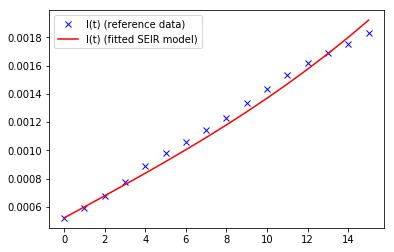

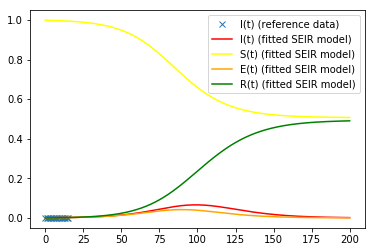

In [23]:
if __name__ == '__main__':
    country = 'Italy' 
    analyze_country(country)